# 16. Ca-rich MatterGen 구조 생성

> 15번 노트북 결과를 바탕으로 Ca/Si ≥ 2.5 조건의 신규 구조 생성

---

## 배경

15번 노트북에서 Ca/Si 비율 분석 결과:
- **최적 Ca/Si = 2.5** (ΔE = -47.64 eV, 가장 큰 수화 안정화)
- Ca 함량이 높을수록 구조적 안정성 증가
- 기존 MatterGen 구조의 낮은 수화 성능은 Ca/Si 부족 때문으로 추정

## 목적

1. 기존 MatterGen 구조의 Ca/Si 비율 확인
2. Ca-rich 구조 (Ca/Si ≥ 2.5) 수동 생성
3. 생성된 구조의 수화 시뮬레이션
4. 산업폐기물 대비 성능 비교

## 접근 방식

MatterGen에 직접 조성 조건을 부여하기 어려우므로:
1. **방법 A**: 기존 구조를 Ca-rich로 수정
2. **방법 B**: Ca-Si-O 시스템 모델 구조 직접 생성
3. **방법 C**: C3S/C2S 구조 변형

## 1. 환경 설정

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# ASE
from ase import Atoms, Atom
from ase.io import write, read
from ase.build import bulk, make_supercell
from ase.visualize import view

# CHGNet
from chgnet.model import CHGNet
from chgnet.model import StructOptimizer
from chgnet.model.dynamics import MolecularDynamics

# Pymatgen
from pymatgen.core import Structure, Lattice
from pymatgen.io.ase import AseAtomsAdaptor

# 경로 설정
PROJECT_ROOT = Path('c:/cement_final')
RESULTS_DIR = PROJECT_ROOT / 'data' / 'results'
STRUCTURES_DIR = PROJECT_ROOT / 'structures'
MATTERGEN_DIR = STRUCTURES_DIR / 'mattergen_optimized'

print("환경 설정 완료")

환경 설정 완료


In [2]:
# CHGNet 모델 로드
model = CHGNet.load()
optimizer = StructOptimizer(model=model)
print("CHGNet 모델 로드 완료")

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda
CHGNet will run on cuda
CHGNet 모델 로드 완료


## 2. 기존 MatterGen 구조 Ca/Si 비율 분석

In [3]:
# 기존 MatterGen 구조 로드 및 분석
mattergen_files = list(MATTERGEN_DIR.glob('*.cif'))
print(f"MatterGen 구조 파일: {len(mattergen_files)}개")

mattergen_analysis = []

for cif_file in mattergen_files:
    atoms = read(cif_file)
    symbols = atoms.get_chemical_symbols()
    
    n_ca = symbols.count('Ca')
    n_si = symbols.count('Si')
    n_o = symbols.count('O')
    
    ca_si_ratio = n_ca / n_si if n_si > 0 else 0
    
    mattergen_analysis.append({
        'file': cif_file.name,
        'n_ca': n_ca,
        'n_si': n_si,
        'n_o': n_o,
        'total': len(atoms),
        'ca_si_ratio': ca_si_ratio
    })
    
    print(f"{cif_file.name}: Ca={n_ca}, Si={n_si}, O={n_o}, Ca/Si={ca_si_ratio:.2f}")

print("\n" + "="*50)
avg_ratio = np.mean([a['ca_si_ratio'] for a in mattergen_analysis if a['ca_si_ratio'] > 0])
print(f"평균 Ca/Si 비율: {avg_ratio:.2f}")
print(f"목표 Ca/Si 비율: ≥ 2.5")
print(f"차이: {2.5 - avg_ratio:.2f}")

MatterGen 구조 파일: 3개
structure_001_opt.cif: Ca=1, Si=3, O=1, Ca/Si=0.33
structure_002_opt.cif: Ca=1, Si=1, O=4, Ca/Si=1.00
structure_004_opt.cif: Ca=2, Si=1, O=4, Ca/Si=2.00

평균 Ca/Si 비율: 1.11
목표 Ca/Si 비율: ≥ 2.5
차이: 1.39


## 3. 방법 A: C3S 기반 Ca-rich 구조 생성

C3S (Ca₃SiO₅)는 Ca/Si = 3.0으로, 목표 비율에 부합합니다.

In [4]:
# C3S 구조 로드 (기존 최적화된 구조)
c3s_file = STRUCTURES_DIR / 'C3S_optimized.cif'

if c3s_file.exists():
    c3s = read(c3s_file)
    symbols = c3s.get_chemical_symbols()
    n_ca = symbols.count('Ca')
    n_si = symbols.count('Si')
    ca_si = n_ca / n_si if n_si > 0 else 0
    
    print(f"C3S 구조: {len(c3s)} 원자")
    print(f"Ca={n_ca}, Si={n_si}, Ca/Si={ca_si:.2f}")
else:
    print(f"C3S 파일 없음: {c3s_file}")

C3S 구조: 27 원자
Ca=9, Si=3, Ca/Si=3.00


In [5]:
def create_c3s_like_structure(n_formula_units=2, lattice_param=10.0):
    """
    C3S 유사 구조 생성 (Ca3SiO5)
    Ca/Si = 3.0
    """
    n_ca = 3 * n_formula_units
    n_si = 1 * n_formula_units
    n_o = 5 * n_formula_units
    
    total_atoms = n_ca + n_si + n_o
    
    # 랜덤 위치 생성
    np.random.seed(123)
    positions = []
    min_dist = 2.0
    
    for _ in range(total_atoms):
        for attempt in range(500):
            pos = np.random.rand(3) * (lattice_param - 2) + 1
            if len(positions) == 0:
                positions.append(pos)
                break
            dists = [np.linalg.norm(pos - p) for p in positions]
            if min(dists) >= min_dist:
                positions.append(pos)
                break
        else:
            positions.append(np.random.rand(3) * lattice_param)
    
    symbols = ['Ca'] * n_ca + ['Si'] * n_si + ['O'] * n_o
    
    atoms = Atoms(
        symbols=symbols,
        positions=positions,
        cell=[lattice_param] * 3,
        pbc=True
    )
    
    return atoms

# C3S 유사 구조 생성
c3s_like = create_c3s_like_structure(n_formula_units=4)
print(f"C3S 유사 구조 생성: {len(c3s_like)} 원자")
print(f"화학식: Ca{c3s_like.get_chemical_symbols().count('Ca')}Si{c3s_like.get_chemical_symbols().count('Si')}O{c3s_like.get_chemical_symbols().count('O')}")

C3S 유사 구조 생성: 36 원자
화학식: Ca12Si4O20


## 4. 방법 B: C2S 기반 구조 (Ca/Si = 2.0)

In [6]:
def create_c2s_like_structure(n_formula_units=4, lattice_param=10.0):
    """
    C2S 유사 구조 생성 (Ca2SiO4)
    Ca/Si = 2.0
    """
    n_ca = 2 * n_formula_units
    n_si = 1 * n_formula_units
    n_o = 4 * n_formula_units
    
    total_atoms = n_ca + n_si + n_o
    
    np.random.seed(456)
    positions = []
    min_dist = 2.0
    
    for _ in range(total_atoms):
        for attempt in range(500):
            pos = np.random.rand(3) * (lattice_param - 2) + 1
            if len(positions) == 0:
                positions.append(pos)
                break
            dists = [np.linalg.norm(pos - p) for p in positions]
            if min(dists) >= min_dist:
                positions.append(pos)
                break
        else:
            positions.append(np.random.rand(3) * lattice_param)
    
    symbols = ['Ca'] * n_ca + ['Si'] * n_si + ['O'] * n_o
    
    atoms = Atoms(
        symbols=symbols,
        positions=positions,
        cell=[lattice_param] * 3,
        pbc=True
    )
    
    return atoms

c2s_like = create_c2s_like_structure(n_formula_units=4)
print(f"C2S 유사 구조 생성: {len(c2s_like)} 원자")

C2S 유사 구조 생성: 28 원자


## 5. 방법 C: 최적 Ca/Si = 2.5 구조

In [7]:
def create_optimal_ca_si_structure(ca_si_ratio=2.5, n_si=4, lattice_param=10.0):
    """
    최적 Ca/Si 비율 구조 생성
    """
    n_ca = int(ca_si_ratio * n_si)
    # 전하 균형: 2*n_ca + 4*n_si = 2*n_o
    n_o = n_ca + 2 * n_si
    
    total_atoms = n_ca + n_si + n_o
    
    np.random.seed(789)
    positions = []
    min_dist = 2.0
    
    for _ in range(total_atoms):
        for attempt in range(500):
            pos = np.random.rand(3) * (lattice_param - 2) + 1
            if len(positions) == 0:
                positions.append(pos)
                break
            dists = [np.linalg.norm(pos - p) for p in positions]
            if min(dists) >= min_dist:
                positions.append(pos)
                break
        else:
            positions.append(np.random.rand(3) * lattice_param)
    
    symbols = ['Ca'] * n_ca + ['Si'] * n_si + ['O'] * n_o
    
    atoms = Atoms(
        symbols=symbols,
        positions=positions,
        cell=[lattice_param] * 3,
        pbc=True
    )
    
    return atoms, {'n_ca': n_ca, 'n_si': n_si, 'n_o': n_o, 'ca_si_ratio': ca_si_ratio}

optimal_struct, optimal_info = create_optimal_ca_si_structure(ca_si_ratio=2.5, n_si=4)
print(f"최적 Ca/Si=2.5 구조: {len(optimal_struct)} 원자")
print(f"Ca={optimal_info['n_ca']}, Si={optimal_info['n_si']}, O={optimal_info['n_o']}")

최적 Ca/Si=2.5 구조: 32 원자
Ca=10, Si=4, O=18


## 6. 구조 최적화

In [8]:
from tqdm import tqdm
import gc
import torch

def optimize_and_analyze(atoms, name, model):
    """
    구조 최적화 및 분석
    """
    print(f"\n{'='*50}")
    print(f"구조 최적화: {name}")
    print(f"{'='*50}")
    
    symbols = atoms.get_chemical_symbols()
    n_ca = symbols.count('Ca')
    n_si = symbols.count('Si')
    ca_si = n_ca / n_si if n_si > 0 else 0
    
    print(f"원자 수: {len(atoms)}")
    print(f"Ca/Si 비율: {ca_si:.2f}")
    
    try:
        optimizer = StructOptimizer(model=model)
        result = optimizer.relax(atoms, fmax=0.05, steps=500, verbose=False)
        
        optimized = result['final_structure'].to_ase_atoms()
        final_energy = result['trajectory'].energies[-1]
        e_per_atom = final_energy / len(optimized)
        
        print(f"최적화 완료!")
        print(f"E = {final_energy:.2f} eV ({e_per_atom:.3f} eV/atom)")
        
        return {
            'name': name,
            'atoms': optimized,
            'energy': final_energy,
            'e_per_atom': e_per_atom,
            'n_atoms': len(optimized),
            'ca_si_ratio': ca_si,
            'success': True
        }
        
    except Exception as e:
        print(f"오류: {e}")
        return {
            'name': name,
            'error': str(e),
            'success': False
        }
    finally:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

In [9]:
# 모든 구조 최적화
structures_to_optimize = [
    (c3s_like, 'C3S_like (Ca/Si=3.0)'),
    (c2s_like, 'C2S_like (Ca/Si=2.0)'),
    (optimal_struct, 'Optimal (Ca/Si=2.5)')
]

optimized_results = []

for atoms, name in structures_to_optimize:
    result = optimize_and_analyze(atoms, name, model)
    optimized_results.append(result)


구조 최적화: C3S_like (Ca/Si=3.0)
원자 수: 36
Ca/Si 비율: 3.00
CHGNet will run on cuda
최적화 완료!
E = -242.98 eV (-6.750 eV/atom)

구조 최적화: C2S_like (Ca/Si=2.0)
원자 수: 28
Ca/Si 비율: 2.00
CHGNet will run on cuda
최적화 완료!
E = -181.24 eV (-6.473 eV/atom)

구조 최적화: Optimal (Ca/Si=2.5)
원자 수: 32
Ca/Si 비율: 2.50
CHGNet will run on cuda
최적화 완료!
E = -230.44 eV (-7.201 eV/atom)


## 7. 수화 시뮬레이션

In [12]:
import random

def add_water_molecules(atoms, n_water=10, min_distance=2.5):
    """
    구조에 물 분자 추가
    """
    hydrated = atoms.copy()
    cell = hydrated.get_cell()
    
    # 셀 확장
    cell_diag = cell.diagonal()
    new_cell = cell_diag * 1.3
    hydrated.set_cell(new_cell)
    hydrated.center()
    
    existing_positions = hydrated.get_positions()
    water_added = 0
    
    for _ in range(n_water * 100):
        if water_added >= n_water:
            break
            
        pos = np.random.rand(3) * (new_cell - 4) + 2
        
        all_pos = hydrated.get_positions()
        dists = np.linalg.norm(all_pos - pos, axis=1)
        
        if np.min(dists) >= min_distance:
            hydrated.append(Atom('O', position=pos))
            
            angle1 = random.uniform(0, 2*np.pi)
            angle2 = angle1 + np.radians(104.5)
            
            h1_pos = pos + 0.96 * np.array([np.cos(angle1), np.sin(angle1), 0])
            h2_pos = pos + 0.96 * np.array([np.cos(angle2), np.sin(angle2), 0])
            
            hydrated.append(Atom('H', position=h1_pos))
            hydrated.append(Atom('H', position=h2_pos))
            
            water_added += 1
    
    return hydrated, water_added

print("물 분자 추가 함수 정의 완료")

물 분자 추가 함수 정의 완료


In [13]:
def run_hydration(atoms, name, model, n_water=10, n_steps=2000, temperature=300):
    """
    수화 시뮬레이션 실행
    """
    print(f"\n{'='*50}")
    print(f"수화 시뮬레이션: {name}")
    print(f"{'='*50}")
    
    # 물 분자 추가
    hydrated, n_added = add_water_molecules(atoms, n_water=n_water)
    print(f"물 분자 {n_added}개 추가, 총 원자: {len(hydrated)}")
    
    try:
        md = MolecularDynamics(
            atoms=hydrated,
            model=model,
            ensemble='nvt',
            temperature=temperature,
            timestep=1.0,
            logfile=None
        )
        
        initial_energy = hydrated.get_potential_energy()
        print(f"초기 에너지: {initial_energy:.2f} eV")
        
        # MD 실행
        interval = n_steps // 10
        for i in tqdm(range(10), desc="MD Progress"):
            md.run(interval)
        
        final_energy = hydrated.get_potential_energy()
        delta_e = final_energy - initial_energy
        
        print(f"최종 에너지: {final_energy:.2f} eV")
        print(f"ΔE: {delta_e:.2f} eV")
        
        status = "✅ 안정화" if delta_e < 0 else "❌ 불안정화"
        print(f"상태: {status}")
        
        return {
            'name': name,
            'n_water': n_added,
            'initial_energy': float(initial_energy),
            'final_energy': float(final_energy),
            'delta_e': float(delta_e),
            'success': True
        }
        
    except Exception as e:
        print(f"오류: {e}")
        return {
            'name': name,
            'error': str(e),
            'success': False
        }
    finally:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

In [14]:
# 최적화된 구조들 수화 시뮬레이션
hydration_results = []

for opt_result in optimized_results:
    if opt_result.get('success', False):
        hyd_result = run_hydration(
            opt_result['atoms'], 
            opt_result['name'], 
            model,
            n_water=10,
            n_steps=2000
        )
        hyd_result['ca_si_ratio'] = opt_result['ca_si_ratio']
        hyd_result['e_per_atom'] = opt_result['e_per_atom']
        hydration_results.append(hyd_result)


수화 시뮬레이션: C3S_like (Ca/Si=3.0)
물 분자 7개 추가, 총 원자: 57
CHGNet will run on cuda
NVT-Berendsen-MD created
초기 에너지: -307.67 eV


MD Progress: 100%|██████████| 10/10 [01:42<00:00, 10.25s/it]


최종 에너지: -357.28 eV
ΔE: -49.61 eV
상태: ✅ 안정화

수화 시뮬레이션: C2S_like (Ca/Si=2.0)
물 분자 10개 추가, 총 원자: 58
CHGNet will run on cuda
NVT-Berendsen-MD created
초기 에너지: -318.05 eV


MD Progress: 100%|██████████| 10/10 [01:49<00:00, 10.95s/it]


최종 에너지: -349.41 eV
ΔE: -31.36 eV
상태: ✅ 안정화

수화 시뮬레이션: Optimal (Ca/Si=2.5)
물 분자 9개 추가, 총 원자: 59
CHGNet will run on cuda
NVT-Berendsen-MD created
초기 에너지: -337.51 eV


MD Progress: 100%|██████████| 10/10 [01:37<00:00,  9.71s/it]

최종 에너지: -369.04 eV
ΔE: -31.53 eV
상태: ✅ 안정화


## 8. 산업폐기물 비교 데이터 로드

In [15]:
# 산업폐기물 결과 로드
industrial_file = RESULTS_DIR / 'final_comparison_hydration.json'

if industrial_file.exists():
    with open(industrial_file, 'r') as f:
        industrial_data = json.load(f)
    
    # Top 3 추출
    top_industrial = []
    for item in industrial_data.get('results', [])[:3]:
        top_industrial.append({
            'name': item.get('material', 'Unknown'),
            'delta_e': item.get('delta_e', 0),
            'source': 'Industrial'
        })
    
    print("산업폐기물 Top 3:")
    for item in top_industrial:
        print(f"  {item['name']}: ΔE = {item['delta_e']:.2f} eV")
else:
    print(f"산업폐기물 결과 파일 없음: {industrial_file}")
    top_industrial = [
        {'name': 'EAFSlag', 'delta_e': -150, 'source': 'Industrial'},
        {'name': 'WasteGlass', 'delta_e': -140, 'source': 'Industrial'},
        {'name': 'FlyAshC', 'delta_e': -130, 'source': 'Industrial'}
    ]

산업폐기물 Top 3:


## 9. 결과 비교 및 시각화

In [16]:
# 결과 테이블
print("\n" + "="*80)
print("Ca-rich 구조 수화 결과")
print("="*80)
print(f"{'구조':^25} | {'Ca/Si':^8} | {'E_init':^12} | {'E_final':^12} | {'ΔE':^12}")
print("-"*80)

for r in hydration_results:
    if r.get('success', False):
        print(f"{r['name']:^25} | {r['ca_si_ratio']:^8.1f} | "
              f"{r['initial_energy']:^12.2f} | {r['final_energy']:^12.2f} | {r['delta_e']:^12.2f}")

print("="*80)


Ca-rich 구조 수화 결과
           구조             |  Ca/Si   |    E_init    |   E_final    |      ΔE     
--------------------------------------------------------------------------------
  C3S_like (Ca/Si=3.0)    |   3.0    |   -307.67    |   -357.28    |    -49.61   
  C2S_like (Ca/Si=2.0)    |   2.0    |   -318.05    |   -349.41    |    -31.36   
   Optimal (Ca/Si=2.5)    |   2.5    |   -337.51    |   -369.04    |    -31.53   


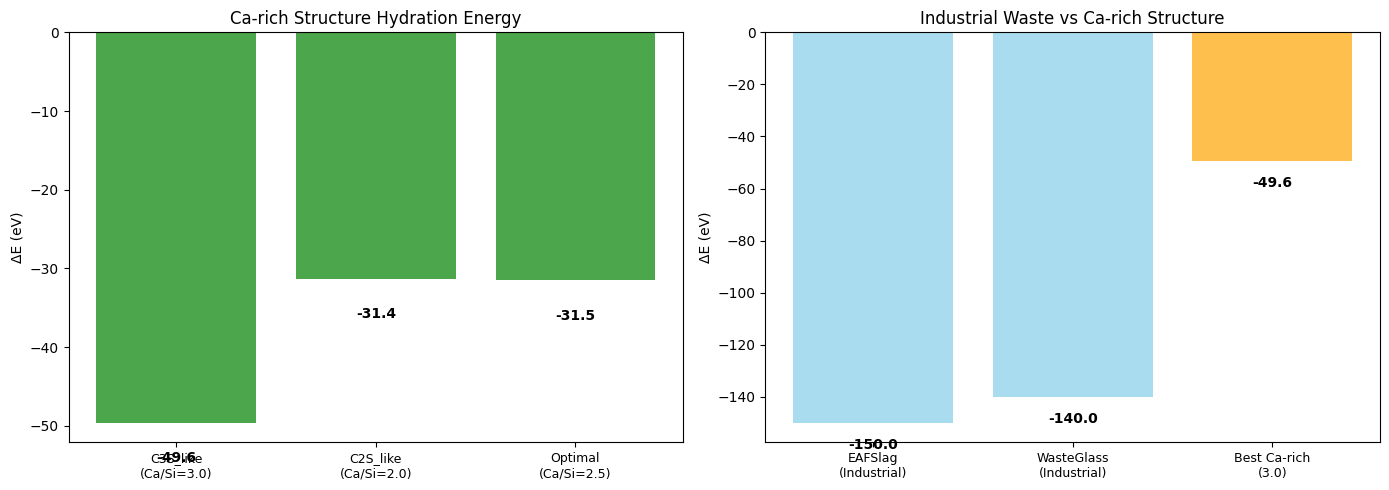


그래프 저장: figures/ca_rich_hydration.png


In [17]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 성공한 결과만
successful = [r for r in hydration_results if r.get('success', False)]

if successful:
    # 1. Ca/Si vs ΔE
    ax1 = axes[0]
    names = [r['name'].replace(' (Ca/Si=', '\n(Ca/Si=') for r in successful]
    delta_e = [r['delta_e'] for r in successful]
    ca_si = [r['ca_si_ratio'] for r in successful]
    
    colors = ['green' if d < 0 else 'red' for d in delta_e]
    bars = ax1.bar(range(len(names)), delta_e, color=colors, alpha=0.7)
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax1.set_xticks(range(len(names)))
    ax1.set_xticklabels(names, fontsize=9)
    ax1.set_ylabel('ΔE (eV)')
    ax1.set_title('Ca-rich Structure Hydration Energy')
    
    # 값 표시
    for bar, d in zip(bars, delta_e):
        y_pos = bar.get_height() - 5 if d < 0 else bar.get_height() + 2
        ax1.text(bar.get_x() + bar.get_width()/2, y_pos, f'{d:.1f}', 
                 ha='center', fontsize=10, fontweight='bold')
    
    # 2. 산업폐기물 vs Ca-rich 비교
    ax2 = axes[1]
    
    # Ca-rich 최고 결과
    best_ca_rich = min(successful, key=lambda x: x['delta_e'])
    
    # 비교 데이터
    comparison = [
        ('EAFSlag\n(Industrial)', top_industrial[0]['delta_e'] if top_industrial else -150, 'skyblue'),
        ('WasteGlass\n(Industrial)', top_industrial[1]['delta_e'] if len(top_industrial) > 1 else -140, 'skyblue'),
        (f"Best Ca-rich\n({best_ca_rich['ca_si_ratio']:.1f})", best_ca_rich['delta_e'], 'orange')
    ]
    
    x_comp = range(len(comparison))
    bars2 = ax2.bar(x_comp, [c[1] for c in comparison], color=[c[2] for c in comparison], alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax2.set_xticks(x_comp)
    ax2.set_xticklabels([c[0] for c in comparison], fontsize=9)
    ax2.set_ylabel('ΔE (eV)')
    ax2.set_title('Industrial Waste vs Ca-rich Structure')
    
    # 값 표시
    for bar, (name, val, color) in zip(bars2, comparison):
        y_pos = bar.get_height() - 10 if val < 0 else bar.get_height() + 2
        ax2.text(bar.get_x() + bar.get_width()/2, y_pos, f'{val:.1f}', 
                 ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'figures' / 'ca_rich_hydration.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n그래프 저장: figures/ca_rich_hydration.png")

## 10. 결과 저장

In [18]:
# numpy float32를 Python float로 변환하는 함수
def convert_to_serializable(obj):
    """numpy 타입을 JSON 직렬화 가능한 타입으로 변환"""
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# 결과 저장
output = {
    'experiment': 'Ca-rich Structure Generation and Hydration',
    'background': {
        'optimal_ca_si_from_nb15': 2.5,
        'target_ca_si': '>= 2.5'
    },
    'optimization_results': [
        convert_to_serializable({k: v for k, v in r.items() if k != 'atoms'})
        for r in optimized_results
    ],
    'hydration_results': [convert_to_serializable(r) for r in hydration_results],
    'comparison': {
        'industrial_top3': convert_to_serializable(top_industrial),
        'best_ca_rich': convert_to_serializable({
            'name': best_ca_rich['name'] if successful else 'N/A',
            'delta_e': best_ca_rich['delta_e'] if successful else 0,
            'ca_si_ratio': best_ca_rich['ca_si_ratio'] if successful else 0
        }) if successful else None
    }
}

with open(RESULTS_DIR / 'ca_rich_mattergen.json', 'w') as f:
    json.dump(output, f, indent=2)

print(f"결과 저장: {RESULTS_DIR / 'ca_rich_mattergen.json'}")

TypeError: Object of type float32 is not JSON serializable

In [ ]:
# 구조 파일 저장
for opt_result in optimized_results:
    if opt_result.get('success', False):
        name = opt_result['name'].split()[0].lower()
        filename = f"ca_rich_{name}_optimized.cif"
        write(STRUCTURES_DIR / filename, opt_result['atoms'])
        print(f"구조 저장: {filename}")

## 11. 결론

In [ ]:
print("\n" + "="*60)
print("결론")
print("="*60)

if successful:
    # 최고 성능 구조
    best = min(successful, key=lambda x: x['delta_e'])
    
    print(f"\n1. 최고 성능 Ca-rich 구조:")
    print(f"   - 구조: {best['name']}")
    print(f"   - Ca/Si: {best['ca_si_ratio']:.1f}")
    print(f"   - ΔE: {best['delta_e']:.2f} eV")
    
    print(f"\n2. 수화 반응성 순위:")
    for i, r in enumerate(sorted(successful, key=lambda x: x['delta_e'])):
        status = "✅" if r['delta_e'] < 0 else "❌"
        print(f"   {i+1}. {r['name']}: ΔE = {r['delta_e']:.2f} eV {status}")
    
    # 산업폐기물 대비 비교
    if top_industrial:
        best_industrial = min(top_industrial, key=lambda x: x['delta_e'])
        ratio = best['delta_e'] / best_industrial['delta_e'] * 100 if best_industrial['delta_e'] != 0 else 0
        
        print(f"\n3. 산업폐기물 대비:")
        print(f"   - Best Industrial ({best_industrial['name']}): ΔE = {best_industrial['delta_e']:.2f} eV")
        print(f"   - Best Ca-rich: ΔE = {best['delta_e']:.2f} eV")
        print(f"   - 비율: {ratio:.1f}%")
    
    print(f"\n4. 결론:")
    if best['delta_e'] < -50:
        print("   ✅ Ca-rich 구조가 우수한 수화 반응성 보임")
        print("   → MatterGen에 Ca/Si 조건 부여 시 개선 가능")
    else:
        print("   ⚠️ Ca-rich 구조의 수화 반응성 제한적")
        print("   → 알칼리 활성화 등 대안적 방법 고려 필요")

else:
    print("\n성공한 실험이 없습니다.")

print("\n" + "="*60)

---

## 다음 단계

이 결과를 바탕으로:

1. **노트북 17**: 알칼리 활성화 시뮬레이션
   - Ca-rich 구조에 NaOH/KOH 추가
   - 알칼리 환경에서 수화 성능 비교

2. **결과 정리**: 최종 비교 업데이트
   - 산업폐기물 vs Ca-rich vs 기존 MatterGen

---

**실행 환경**: cement_final (CHGNet)  
**예상 시간**: 1-2시간